In [188]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn
import random
from NecessaryModules.getData import getData
from NecessaryModules.splitData import split_data


In [189]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [190]:
filename = 'Dataset/ionosphere.csv'
dataset,label=getData(filename)
# dataset=pd.DataFrame(dataset) #from dataset_list to dataset_dataframe after suffling
print(dataset)
print(label)

[[1.0, 0.0, 0.99539, -0.05889, 0.85243, 0.02306, 0.83398, -0.37708, 1.0, 0.0376, 0.85243, -0.17755, 0.59755, -0.44945, 0.60536, -0.38223, 0.84356, -0.38542, 0.58212, -0.32192, 0.56971, -0.29674, 0.36946, -0.47357, 0.56811, -0.51171, 0.41078, -0.46168, 0.21266, -0.3409, 0.42267, -0.54487, 0.18641, -0.453], [1.0, 0.0, 1.0, -0.18829, 0.93035, -0.36156, -0.10868, -0.93597, 1.0, -0.04549, 0.50874, -0.67743, 0.34432, -0.69707, -0.51685, -0.97515, 0.05499, -0.62237, 0.33109, -1.0, -0.13151, -0.453, -0.18056, -0.35734, -0.20332, -0.26569, -0.20468, -0.18401, -0.1904, -0.11593, -0.16626, -0.06288, -0.13738, -0.02447], [1.0, 0.0, 1.0, -0.03365, 1.0, 0.00485, 1.0, -0.12062, 0.88965, 0.01198, 0.73082, 0.05346, 0.85443, 0.00827, 0.54591, 0.00299, 0.83775, -0.13644, 0.75535, -0.0854, 0.70887, -0.27502, 0.43385, -0.12062, 0.57528, -0.4022, 0.58984, -0.22145, 0.431, -0.17365, 0.60436, -0.2418, 0.56045, -0.38238], [1.0, 0.0, 1.0, -0.45161, 1.0, 1.0, 0.71216, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.

In [191]:
X_train, y_train, X_test, y_test = split_data(dataset,label)
len(y_test)

111

In [192]:
import pickle

# Load the encoder model from the saved file
with open("Encoder/Encoder_10.pkl", "rb") as file: #"rb"= read mode
    encoder = pickle.load(file)

encoder


In [193]:
encoded_X = pd.DataFrame(encoder.predict(dataset))
encoded_X = encoded_X.add_prefix('feature_')

encoded_X_train = pd.DataFrame(encoder.predict(X_train))
encoded_X_train = encoded_X_train.add_prefix('feature_')

encoded_X_test = pd.DataFrame(encoder.predict(X_test))
encoded_X_test = encoded_X_test.add_prefix('feature_')



11/11 [==============================] - 0s 998us/step


4/4 [==============================] - 0s 1ms/step


# tune_MLP

In [194]:
# train the model with random parameter
from sklearn.neural_network import MLPClassifier

model_MLP = MLPClassifier(
     hidden_layer_sizes=120,
     random_state=42,
     max_iter=300,
     solver="adam"

     
     
     
        
     )

model_MLP.fit(encoded_X_train, y_train)

MLPClassifier(hidden_layer_sizes=120, max_iter=300, random_state=42)

In [195]:
# Finding mean absolute error
preds = model_MLP.predict(encoded_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.09009009009009009

In [196]:
#Use Optuna to find the best hyperparameters
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
K = 5 # stratified 5 fold cross validation, The folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)

train_tunned= np.array(encoded_X)
target_train_tunned= np.array(label)

oof_preds= np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective_MLP(trial):

 for train_index, val_index in (skf.split(encoded_X,label)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    param={
        'hidden_layer_sizes':trial.suggest_int("hidden_layer_sizes", 150, 500),
        # solver=trial.suggest_categorical("solver", ["lbfgs", "sgd", "adam"]),
        'learning_rate':trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"]),
        'random_state':trial.suggest_int("random_state",0, 10),
        'max_iter':trial.suggest_int("max_iter",100,1000),
        'activation':trial.suggest_categorical("activation", ["logistic", "tanh", "relu"]),
        'batch_size':trial.suggest_int("batch_size",2,20),
        'verbose':False
    }
    model=MLPClassifier(**param)
    model.fit(train_X, train_Y)
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X
 mae = mean_absolute_error(target_train_tunned, oof_preds)
 return mae

In [197]:
# this is the main optuna for optimizing a object-->"objective"
import optuna
study_MLP = optuna.create_study(direction='minimize',study_name="MLP_tunning")

[I 2024-02-11 12:53:20,403] A new study created in memory with name: MLP_tunning


In [198]:

study_MLP.optimize(objective_MLP, n_trials=5) 
print('Number of finished trials:', len(study_MLP.trials))
print('Best trial:', study_MLP.best_trial.params)

[I 2024-02-11 12:53:24,768] Trial 0 finished with value: 0.150997150997151 and parameters: {'hidden_layer_sizes': 457, 'learning_rate': 'invscaling', 'random_state': 10, 'max_iter': 328, 'activation': 'tanh', 'batch_size': 19}. Best is trial 0 with value: 0.150997150997151.
[I 2024-02-11 12:53:45,058] Trial 1 finished with value: 0.09401709401709402 and parameters: {'hidden_layer_sizes': 295, 'learning_rate': 'adaptive', 'random_state': 6, 'max_iter': 324, 'activation': 'relu', 'batch_size': 3}. Best is trial 1 with value: 0.09401709401709402.
[I 2024-02-11 12:53:54,598] Trial 2 finished with value: 0.16809116809116809 and parameters: {'hidden_layer_sizes': 318, 'learning_rate': 'constant', 'random_state': 8, 'max_iter': 260, 'activation': 'logistic', 'batch_size': 7}. Best is trial 1 with value: 0.09401709401709402.
[I 2024-02-11 12:54:11,871] Trial 3 finished with value: 0.09971509971509972 and parameters: {'hidden_layer_sizes': 404, 'learning_rate': 'constant', 'random_state': 10, '

Number of finished trials: 5
Best trial: {'hidden_layer_sizes': 295, 'learning_rate': 'adaptive', 'random_state': 6, 'max_iter': 324, 'activation': 'relu', 'batch_size': 3}


In [199]:
#evaluate the trial
print("Number of finished trials: ", len(study_MLP.trials))
print("Best trial:")
trial = study_MLP.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  5
Best trial:
  Value:  0.09401709401709402
  Params: 
    hidden_layer_sizes: 295
    learning_rate: adaptive
    random_state: 6
    max_iter: 324
    activation: relu
    batch_size: 3


In [200]:
from matplotlib import pyplot as plt
fig_study = optuna.visualization.plot_parallel_coordinate(study_MLP, params=["hidden_layer_sizes", "learning_rate","random_state","max_iter","batch_size"])
fig_study.show()

# fit tunned MLP

In [201]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train_MLP = np.array(encoded_X_train)
target_train_MLP= np.array(y_train)

test_MLP = np.array(encoded_X_test) # or test_Ada = np.array(X)


test_preds_MLP = np.zeros((len(test_MLP)))
oof_preds_MLP = np.zeros((len(train_MLP)))

for train_index, val_index in tqdm(skf.split(encoded_X_train,y_train), total=5):
    train_X, valid_X = train_MLP[train_index], train_MLP[val_index]
    train_y, valid_y = target_train_MLP[train_index], target_train_MLP[val_index]
    ada_params = study_MLP.best_trial.params
    model_MLP_2 = MLPClassifier(**ada_params,tol=.00001,early_stopping=True) # for early_stopping
    model_MLP_2.fit(train_X, train_y)
    # for train accuracy
    preds = model_MLP_2.predict(valid_X)
    oof_preds_MLP[val_index] = preds
    # for test accuracy
    preds = model_MLP_2.predict(test_MLP)
    test_preds_MLP += (preds)/5
print(np.abs(oof_preds_MLP-target_train_MLP).mean())

100%|██████████| 5/5 [00:02<00:00,  2.27it/s]

0.16666666666666666


In [202]:
target_test_MLP = np.array(y_test)

In [203]:
from sklearn.metrics import accuracy_score
valid_Acc_MLP=accuracy_score(target_train_MLP,oof_preds_MLP)
print(valid_Acc_MLP)

# another technique for calculate test accuracy
test_Acc_MLP=accuracy_score(target_test_MLP,test_preds_MLP.round())
print(test_Acc_MLP)

0.8333333333333334
0.8558558558558559


In [204]:
train_Acc_MLP=model_MLP_2.score(encoded_X_train,y_train)
print(train_Acc_MLP)

0.8875


In [205]:
test_Acc_MLP=model_MLP_2.score(encoded_X_test,y_test)
print(test_Acc_MLP)

0.9009009009009009


# Evaluation

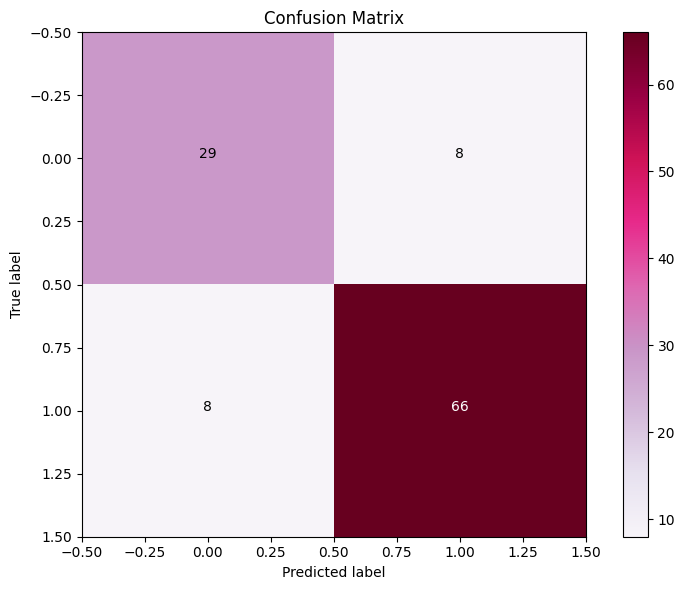

In [206]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds_MLP.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()


# Learning _Curve


In [207]:
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
################# it will take 0.8 as train data from the whole by-default ################
ada_params = study_MLP.best_trial.params
model_MLP_2 = MLPClassifier(**ada_params,tol=.00001,early_stopping=True) # for early_stopping
train_sizes, train_scores, test_scores = learning_curve(model_MLP_2, encoded_X, label, train_sizes=np.linspace(0.1, 1.0, 5))

In [208]:
#***** Calculate mean and standard deviation of train and test scores (as we got values for 5 fold cross in each row****)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

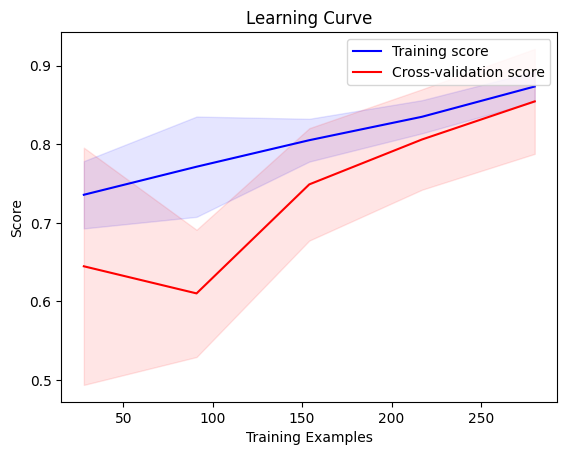

In [209]:
# Plot learning curves
plt.figure()
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1) #alpha=0.1: The transparency of the shaded region.
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='red')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()